## Practical 2. Text Classification with Naive Bayes, Logistic Regression, SVM
### Strictly used for internal purpose in Singapore Polytechnic. Do not disclose!
Overview: This notebook aims to give you a brief overview of performing text classification using Naive Bayes, Logistic Regression and Support Vector Machines. We will be using a dataset called "Economic news article tone and relevance" from Figure-Eight which consists of approximately 8000 news articles, which were tagged as relevant or not relevant to the US Economy. Our goal in this notebook is to explore the process of training and testing text classifiers for this problem, using this data set and two text classification algorithms: Multinomial Naive Bayes and Logistic Regression, implemented in sklearn.

In [8]:
import numpy as np
import pandas as pd

import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn import metrics

from time import time

### 1. Loading and explore dataset

In [9]:
df = pd.read_csv("Data/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )
df[['text', 'relevance']].head(5)

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,yes
1,The Wall Street Journal Online</br></br>The Mo...,no
2,WASHINGTON -- In an effort to achieve banking ...,no
3,The statistics on the enormous costs of employ...,no
4,NEW YORK -- Indecision marked the dollar's ton...,yes


In [3]:
display(df.shape) #Number of rows (instances) and columns in the dataset
df["relevance"].value_counts()/df.shape[0] #Class distribution in the dataset

(8000, 15)

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

There is an imbalance in the data with not relevant being 82% in the dataset. That is, most of the articles are not relevant to US Economy, which makes sense in a real-world scenario, as news articles discuss various topics. We should keep this class imbalance in mind when interpreting the classifier performance later. Let us first convert the class labels into binary outcome variables for convenience. 1 for Yes (relevant), and 0 for No (not relevant), and ignore "Not sure".

In [4]:
# convert label to a numerical variable
df = df[df.relevance != "not sure"]
df['relevance'] = df.relevance.map({'yes':1, 'no':0}) #relevant is 1, not-relevant is 0. 
df = df[["text","relevance"]]
df.shape

(7991, 2)

### 2. text pre-processing
Typical steps involve tokenization, lower casing, removing, stop words, punctuation markers etc, and vectorization. Other processes such as stemming/lemmatization can also be performed. Here, we are performing the following steps: removing br tags, punctuation, numbers, and stopwords. While we are using sklearn's list of stopwords, there are several other stop word lists (e.g., from NLTK) or sometimes, custom stopword lists are needed depending on the task.

In [5]:
stopwords = stop_words.ENGLISH_STOP_WORDS
def clean(doc): #doc is a string of text
    doc = doc.replace("</br>", " ") #This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    return doc

### 3. Modelling
Now we are ready for the modelling. We are going to use algorithms from sklearn package. We will go through the following steps:

1. Split the data into training and test sets (75% train, 25% test)
2. Extract features from the training data using CountVectorizer, which is a bag of words feature implementation. We will use the pre-processing function above in conjunction with Count Vectorizer
3. Transform the test data into the same feature vector as the training data.
4. Train the classifier
5. Evaluate the classifier

In [6]:
#Step 1: train-test split
X = df.text 
y = df.relevance
print('Total Data Size', X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print('Training Data Size', X_train.shape)
print('Testing Data Size', X_test.shape)

Total Data Size (7991,)
Training Data Size (5993,)
Testing Data Size (1998,)


In [7]:
# Step 2: Vectorize train and test data
vect = CountVectorizer(preprocessor=clean) #using the clean function that we created
X_train_dtm = vect.fit_transform(X_train) # vectorize training data

X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)
# i.e., the dimension of our feature size is 49753!

(5993, 49753) (1998, 49753)


In [80]:
#Step 3: Train the classifier and predict for test data
nb = MultinomialNB() 
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

Accuracy:  0.7822822822822822
ROC_AOC_Score:  0.7251117679464362


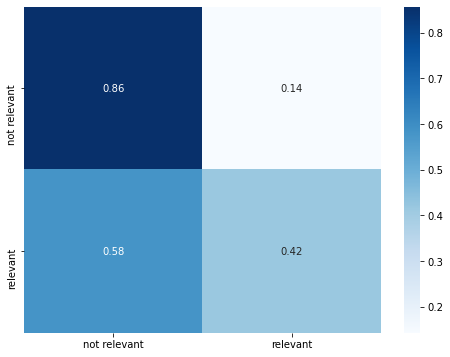

In [81]:
#Step 4: Evaluate the classifier using various measures

print("Accuracy: ", accuracy_score(y_test, y_pred_class))

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))
    
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class, labels=[0, 1])
plt.figure(figsize=(8,6))
sns.heatmap(cnf_matrix / cnf_matrix.sum(axis=1).reshape(2,1),
            cmap='Blues', annot=True, fmt='.2',
            xticklabels=['not relevant', 'relevant'],
            yticklabels=['not relevant', 'relevant'])
plt.show()

## Reduce Feature Size

Accuracy:  0.6881881881881882


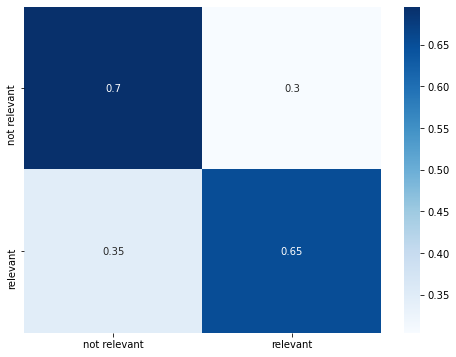

In [82]:
vect = CountVectorizer(preprocessor=clean, max_features=5000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() 
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class, labels=[0, 1])
plt.figure(figsize=(8,6))
sns.heatmap(cnf_matrix / cnf_matrix.sum(axis=1).reshape(2,1),
            cmap='Blues', annot=True, fmt='.2',
            xticklabels=['not relevant', 'relevant'],
            yticklabels=['not relevant', 'relevant'])
plt.show()

## Support Vector Machine algorithm

Accuracy:  0.7252252252252253
AUC:  0.7251117679464362


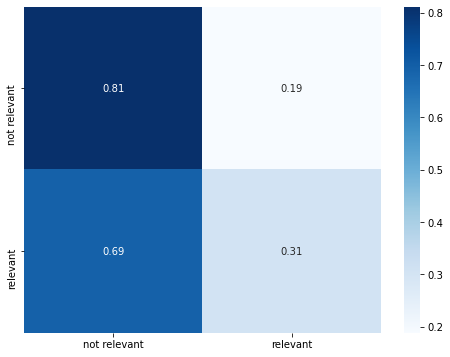

In [87]:
vect = CountVectorizer(preprocessor=clean, max_features=5000)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') #instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train)

#Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class, labels=[0, 1])
plt.figure(figsize=(8,6))
sns.heatmap(cnf_matrix / cnf_matrix.sum(axis=1).reshape(2,1),
            cmap='Blues', annot=True, fmt='.2',
            xticklabels=['not relevant', 'relevant'],
            yticklabels=['not relevant', 'relevant'])
plt.show()